In [8]:
pip install hyperopt lightgbm

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.6 MB ? eta -:--:--
   ---------- ----------------------------- 0.4/1.6 MB 5.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.6 MB 5.0 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.6 MB 5.1 MB/s eta 0:00:01
   -------------------------------- ------- 1.3/1.6 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/491.3 kB ? eta -:--:--
   ------------------------- ------------- 317.4/491.3 kB 19.2 MB/s eta 0:00:01
   ---------------------------------------- 491.3/491.3 kB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


from xgboost import XGBClassifier
import lightgbm as lgb
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import optuna

In [3]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTR,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.520994,-0.945689,0.186303,-0.36088,1.697256,0.0,1.0,14.0,3.0,10.0,...,0,1,0,0,0,0,0,0,1,0
1,1.843288,-0.812861,0.509638,-0.36088,1.297697,0.0,1.0,14.0,5.0,9.0,...,1,0,0,0,0,0,0,0,1,0
2,1.739561,-0.680033,0.509638,-0.36088,0.571225,0.0,0.0,6.0,2.0,16.0,...,0,0,0,0,0,0,1,0,1,0
3,1.335768,-0.414377,0.822195,-0.36088,0.284269,0.0,0.0,15.0,1.0,3.0,...,0,1,0,0,0,0,0,0,1,0
4,0.963463,-0.015893,0.940751,-0.36088,1.297697,0.0,2.0,30.0,10.0,14.0,...,0,1,0,0,0,0,0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1099 non-null   float64
 1   Humidity                   1099 non-null   float64
 2   WindDirection              1099 non-null   float64
 3   Precipitation              1099 non-null   float64
 4   WindSpeed                  1099 non-null   float64
 5   Home_Prv_FTR               1099 non-null   float64
 6   Home_Prv_FTHG              1099 non-null   float64
 7   Home_Prv_HS                1099 non-null   float64
 8   Home_Prv_HST               1099 non-null   float64
 9   Home_Prv_HF                1099 non-null   float64
 10  Home_Prv_HC                1099 non-null   float64
 11  Home_Prv_HY                1099 non-null   float64
 12  Home_Prv_HR                1099 non-null   float64
 13  Home_Prv_3_FTHG            1099 non-null   float

In [4]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [5]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 37), (722,), (377, 37), (377,))

In [ ]:
def objective(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    }
    
    # Train the model
    lgb_train = lgb.Dataset(X, y)
    gbm = lgb.train(param, lgb_train)
    
    # Predict on the training set itself (we'll split train data within each trial to evaluate)
    preds = gbm.predict(X)
    pred_labels = [1 if i > 0.5 else 0 for i in preds]
    
    # Calculate accuracy
    accuracy = accuracy_score(y, pred_labels)
    return accuracy

# Function to perform Bayesian Optimization using Optuna
def perform_bayesian_optimization(X, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    return study.best_trial.params

# Perform Bayesian Optimization and get the best parameters (with weather data)
best_params = perform_bayesian_optimization(X_train, y_train)

# Train the final LightGBM model with the best parameters
model_lgb = lgb.LGBMClassifier(**best_params)
model_lgb.fit(X_train, y_train)

# Predict on the test data (with weather data)
y_pred = model_lgb.predict(X_test)




# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

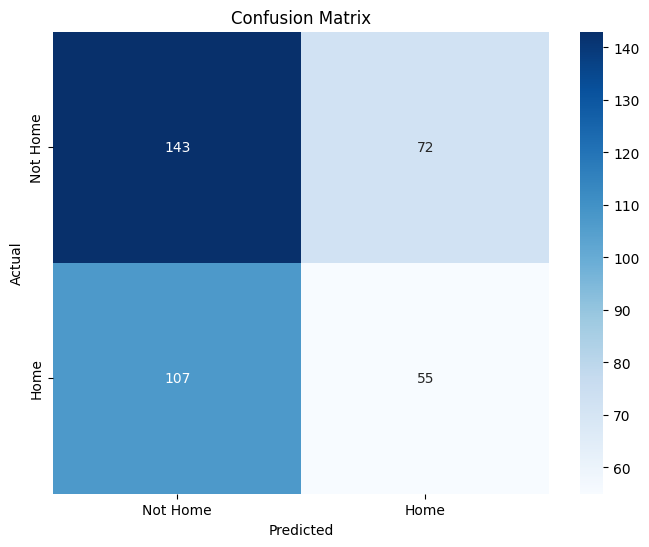

{'max_depth': 14, 'num_leaves': 54, 'learning_rate': 0.15283988515272365, 'n_estimators': 197, 'min_child_samples': 41, 'subsample': 0.8096405468220081, 'colsample_bytree': 0.7806741589620677, 'reg_alpha': 0.025054977389726545, 'reg_lambda': 0.027878941159203807}
MCC: 0.004841470321970519
accuracy: 0.5251989389920424
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       215
           1       0.43      0.34      0.38       162

    accuracy                           0.53       377
   macro avg       0.50      0.50      0.50       377
weighted avg       0.51      0.53      0.51       377



In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

### Model without Weather Data:

In [16]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 24), (722,), (377, 24), (377,))

In [ ]:
def objective(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    }
    
    # Train the model
    lgb_train = lgb.Dataset(X, y)
    gbm = lgb.train(param, lgb_train)
    
    # Predict on the training set itself (we'll split train data within each trial to evaluate)
    preds = gbm.predict(X)
    pred_labels = [1 if i > 0.5 else 0 for i in preds]
    
    # Calculate accuracy
    accuracy = accuracy_score(y, pred_labels)
    return accuracy

# Function to perform Bayesian Optimization using Optuna
def perform_bayesian_optimization(X, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    return study.best_trial.params

# Perform Bayesian Optimization and get the best parameters (with weather data)
best_params = perform_bayesian_optimization(X_train, y_train)

# Train the final LightGBM model with the best parameters
model_lgb = lgb.LGBMClassifier(**best_params)
model_lgb.fit(X_train, y_train)

# Predict on the test data (with weather data)
y_pred = model_lgb.predict(X_test)




# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

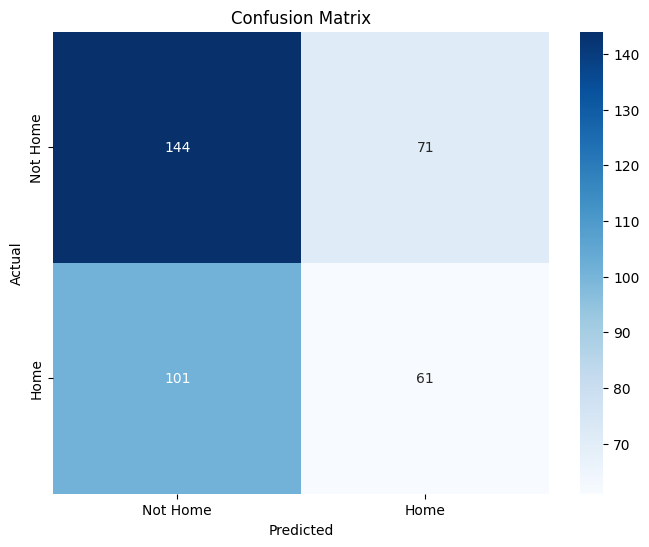

{'max_depth': 9, 'num_leaves': 37, 'learning_rate': 0.14868388101922506, 'n_estimators': 166, 'min_child_samples': 15, 'subsample': 0.7291360088613401, 'colsample_bytree': 0.8580584759700827, 'reg_alpha': 0.028978088216588267, 'reg_lambda': 1.4220931936434222}
MCC: 0.048060426705173104
accuracy: 0.5437665782493368
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       215
           1       0.46      0.38      0.41       162

    accuracy                           0.54       377
   macro avg       0.52      0.52      0.52       377
weighted avg       0.53      0.54      0.54       377



In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)